
The input is 96x96x3 and the output is a 128d vector 



In [15]:
from model import create_model
nn4_small2 = create_model()

In [16]:
nn4_small2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 48, 48, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [17]:
import bz2
import os

from urllib.request import urlopen

def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

dst_dir = 'models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    download_landmarks(dst_file)

In [18]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Layer

# Input for anchor, positive and negative images
in_a = Input(shape=(96, 96, 3))
in_p = Input(shape=(96, 96, 3))
in_n = Input(shape=(96, 96, 3))

# Output for anchor, positive and negative embedding vectors
# The nn4_small model instance is shared (Siamese network)
emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)


In [19]:
nn4_small2_train.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          3743280     input_5[0][0]                    
                                                                 input_6[0][0]                    
          

In [20]:
from data import triplet_generator

generator = triplet_generator() 

nn4_small2_train.compile(loss=None, optimizer='adam')
nn4_small2_train.fit_generator(generator, epochs=1, steps_per_epoch=10)

Epoch 1/1
10/10 [==============================] - 58s 6s/step - loss: 0.7990


# Using a pre-trained OpenFace model on a custom dataset

Implementation of FaceNet trained on the public datasets FaceScrub and CASIA-WebFace

## Load the pre-trained model

In [26]:
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('weights/nn4.small2.v1.h5')

## Prep the dataset

In [7]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

In [21]:
metadata = load_metadata('tess_images')
print(metadata)

[tess_images\Angelina_Jolie\Angelina_Jolie_0001.jpg
 tess_images\Angelina_Jolie\Angelina_Jolie_0002.jpg
 tess_images\Angelina_Jolie\Angelina_Jolie_0003.jpg
 tess_images\Angelina_Jolie\Angelina_Jolie_0004.jpg
 tess_images\Angelina_Jolie\Angelina_Jolie_0005.jpg
 tess_images\Angelina_Jolie\Angelina_Jolie_0006.jpg
 tess_images\Angelina_Jolie\Angelina_Jolie_0007.jpg
 tess_images\Angelina_Jolie\Angelina_Jolie_0008.jpg
 tess_images\Angelina_Jolie\Angelina_Jolie_0009.jpg
 tess_images\Angelina_Jolie\Angelina_Jolie_0010.jpg
 tess_images\Bill_Clinton\Bill_Clinton_0001.jpg
 tess_images\Bill_Clinton\Bill_Clinton_0002.jpg
 tess_images\Bill_Clinton\Bill_Clinton_0003.jpg
 tess_images\Bill_Clinton\Bill_Clinton_0004.jpg
 tess_images\Bill_Clinton\Bill_Clinton_0005.jpg
 tess_images\Bill_Clinton\Bill_Clinton_0006.jpg
 tess_images\Bill_Clinton\Bill_Clinton_0007.jpg
 tess_images\Bill_Clinton\Bill_Clinton_0008.jpg
 tess_images\Bill_Clinton\Bill_Clinton_0009.jpg
 tess_images\Bill_Clinton\Bill_Clinton_0010.jpg


In [22]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

# OpenCV loads images with color channels
# in BGR order. So we need to reverse them
def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('models/landmarks.dat')

def show_original_and_aligned(img_index):
    plt.figure(figsize=(10,10))
    # Load an image
    original = load_image(metadata[img_index].image_path())

    # Detect face and return bounding box
    bb = alignment.getLargestFaceBoundingBox(original)

    # Transform image using specified face landmark indices and crop image to 96x96
    aligned = alignment.align(96, original, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

    # Show original image
    plt.subplot(131)
    plt.imshow(original)

    # Show original image with bounding box
    plt.subplot(132)
    plt.imshow(original)
    plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

    # Show aligned image
    plt.subplot(133)
    plt.imshow(aligned)

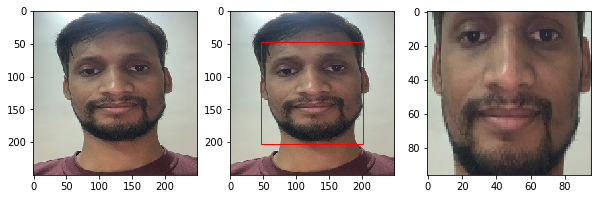

In [23]:
show_original_and_aligned(79)

In [24]:
#define for future use

def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

### Generate Embedding Vectors

In [27]:
from progressbar import ProgressBar

num_images = metadata.shape[0]
progress = ProgressBar(num_images)
progress.start()

embedded = np.zeros((num_images, 128))

for i, m in enumerate(metadata):
    #print(m.image_path())    
    img = load_image(m.image_path())
    img = align_image(img)
    # scale RGB values to interval [0,1]
    img = (img / 255.).astype(np.float32)
    # obtain embedding vector for image
    embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
    progress.update(i)

\ |         #                                       | 153 Elapsed Time: 0:01:27

In [145]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(10,5))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

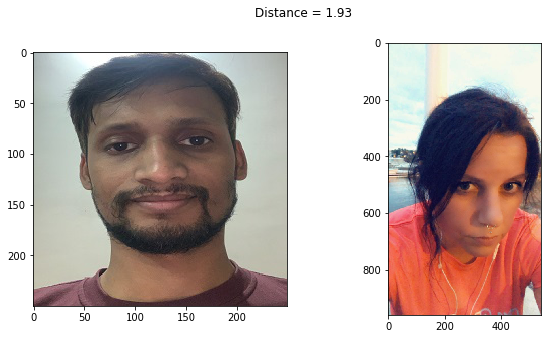

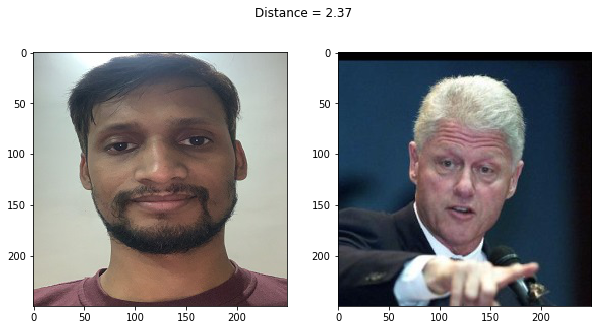

In [157]:
show_pair(79,94)
show_pair(79,10)

# What is the best threshold for the verification problem (Distance Treshold)

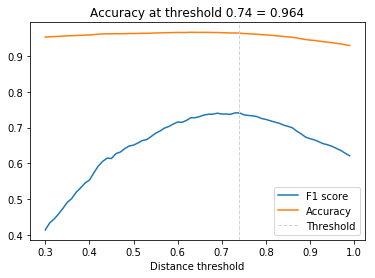

In [147]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

## Distance distributions of positive and negative pairs

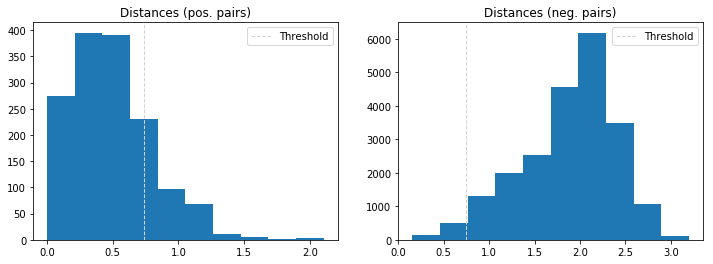

In [148]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

# Face recognition - with KNN or an SVM

50% used for training  
50% for validation

In [156]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

targets = np.array([m.name for m in metadata])
print("Targets ",targets)
encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

test_idx = np.arange(metadata.shape[0]) % 2 != 0
train_idx = np.arange(metadata.shape[0]) % 2 == 0

# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
y_pred_svc = knn.predict(X_test)
acc_svc = accuracy_score(y_test, y_pred_svc)

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

Targets  ['Angelina_Jolie' 'Angelina_Jolie' 'Angelina_Jolie' 'Angelina_Jolie'
 'Angelina_Jolie' 'Angelina_Jolie' 'Angelina_Jolie' 'Angelina_Jolie'
 'Angelina_Jolie' 'Angelina_Jolie' 'Bill_Clinton' 'Bill_Clinton'
 'Bill_Clinton' 'Bill_Clinton' 'Bill_Clinton' 'Bill_Clinton'
 'Bill_Clinton' 'Bill_Clinton' 'Bill_Clinton' 'Bill_Clinton' 'Bill_Gates'
 'Bill_Gates' 'Bill_Gates' 'Bill_Gates' 'Bill_Gates' 'Bill_Gates'
 'Bill_Gates' 'Bill_Gates' 'Bill_Gates' 'Bill_Gates' 'Britney_Spears'
 'Britney_Spears' 'Britney_Spears' 'Britney_Spears' 'Britney_Spears'
 'Britney_Spears' 'Britney_Spears' 'Britney_Spears' 'Britney_Spears'
 'Britney_Spears' 'Catherine_Zeta-Jones' 'Catherine_Zeta-Jones'
 'Catherine_Zeta-Jones' 'Catherine_Zeta-Jones' 'Catherine_Zeta-Jones'
 'Catherine_Zeta-Jones' 'Catherine_Zeta-Jones' 'Catherine_Zeta-Jones'
 'Catherine_Zeta-Jones' 'Catherine_Zeta-Jones' 'David_Beckham'
 'David_Beckham' 'David_Beckham' 'David_Beckham' 'David_Beckham'
 'David_Beckham' 'David_Beckham' 'David_Beckham

In [142]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

def show_prediction(example_idx):
    plt.figure()
    example_image = load_image(metadata[test_idx][example_idx].image_path())
    print("test_idx",test_idx)
    print("example_idx",test_idx)
    example_prediction = knn.predict([embedded[test_idx][example_idx]])
    example_identity = encoder.inverse_transform(example_prediction)[0]

    plt.imshow(example_image)
    plt.title(f'Recognized as {example_identity}');
    
def show_predictions(indexes):
    plt.figure(figsize=(16,16))
    
    for i, idx in enumerate(indexes[:16]):
        example_image = load_image(metadata[test_idx][idx].image_path())
        example_prediction = knn.predict([embedded[test_idx][idx]])
        example_identity = encoder.inverse_transform(example_prediction)[0]

        plt.subplot(4,4,i+1)
        plt.imshow(example_image)
        plt.title(f'Recognized as {example_identity}');    
def show_me(index):
    plt.figure()
    example_image = load_image(metadata[index].image_path())
    example_prediction = knn.predict([embedded[test_idx][index]])
    example_identity = encoder.inverse_transform(example_prediction)[0]
    plt.imshow(example_image)
    plt.title(f'Recognized as {example_identity}');

tess_images\Samir\file1-10.jpeg


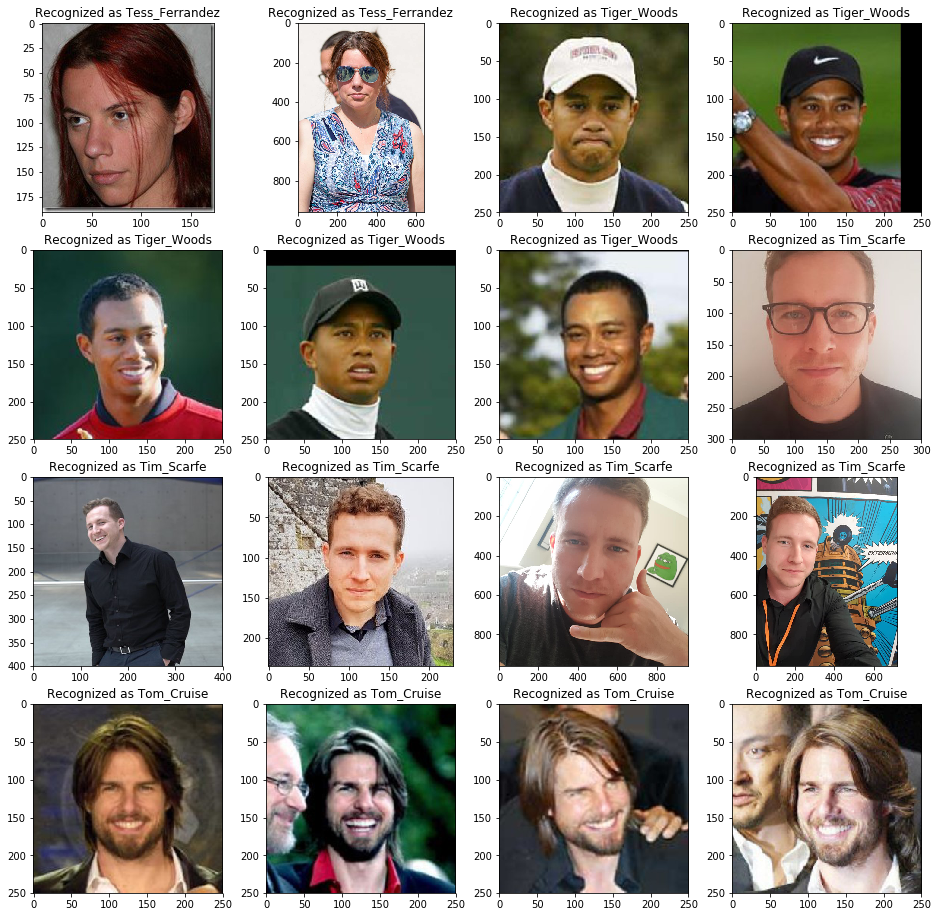

In [158]:
print(metadata[79])

show_predictions(range(50,100))

In [ ]:
show_predictions(range(50,100))

tess_images\Samir\file1-10.jpeg


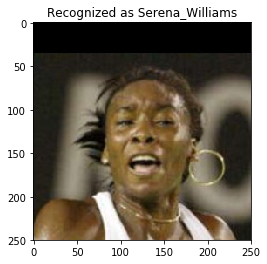

In [93]:
show_prediction(76)

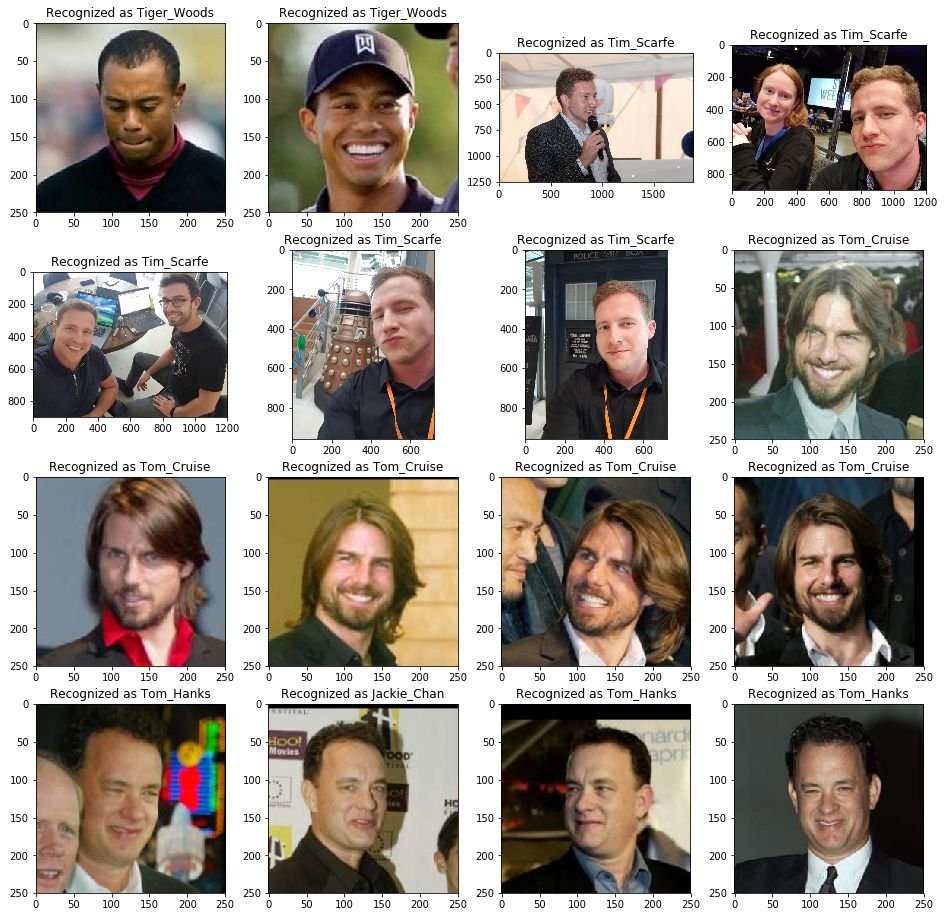

In [79]:
show_predictions(range(55,80))

## Missclassified images

[10, 18, 25, 39, 41, 54, 68, 76]


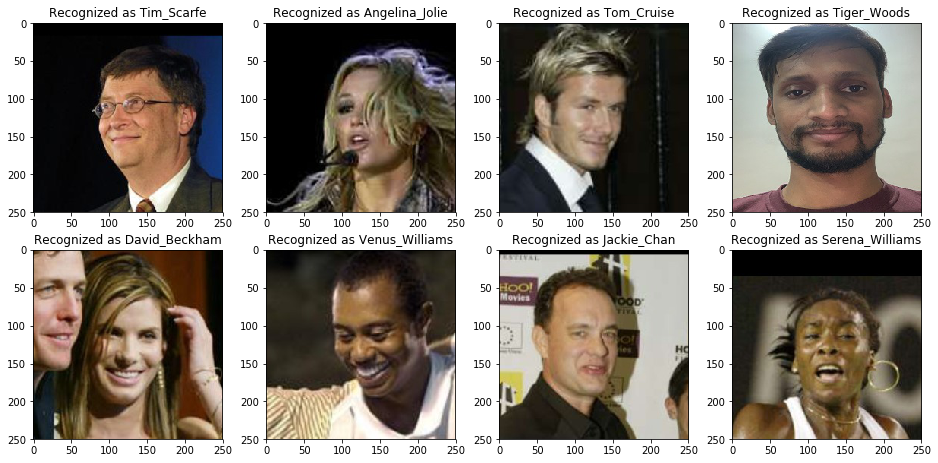

In [80]:
error_pairs = []

for i, item in enumerate(y_pred_knn):
    if item != y_test[i]:
        error_pairs.append(i)
        
print(error_pairs)

show_predictions(error_pairs)


# Dataset visualization

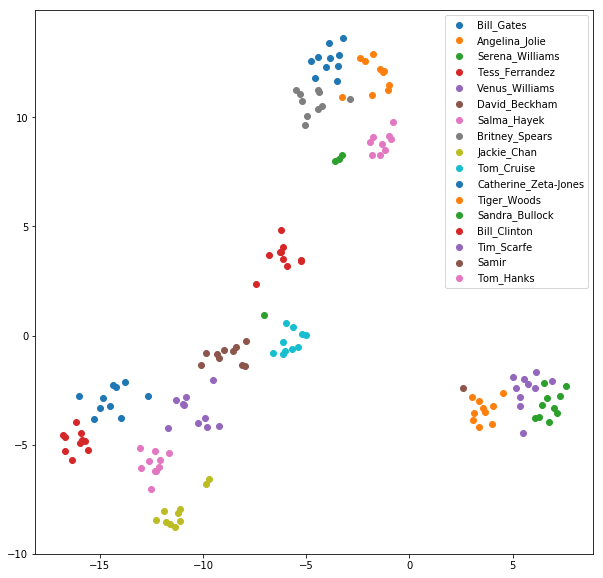

In [159]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

plt.figure(figsize=(10,10))

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

In [171]:
## Save Model as 
import pickle
filename="saved_modle.pkl"
pickle.dump(knn,open(filename,"wb"))


In [172]:
## Loading model
loaded_model=pickle.load(open(filename,"rb"))
print(loaded_model)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')


In [178]:
def predict_face(example_idx,model):
    plt.figure()
    example_image = load_image(metadata[test_idx][example_idx].image_path())
    #print("test_idx",test_idx)
    #print("example_idx",test_idx)
    example_prediction = model.predict([embedded[test_idx][example_idx]])
    example_identity = encoder.inverse_transform(example_prediction)[0]

    plt.imshow(example_image)
    plt.title(f'Recognized as {example_identity}');

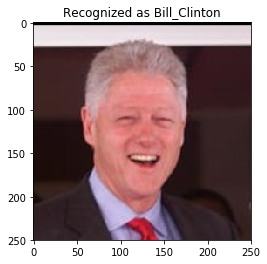

In [186]:
## Check either working it after reading back the save model
predict_face(5,loaded_model)

In [187]:
from platform import python_version
print(python_version())

3.6.8
